Group member: Jinyu Xu, Gloria Wang, Neil Tran, Akshit Khatri

## Abstract

This project aimed to apply a Conditional Variational Autoencoder (CVAE) with dynamic β-VAE to generate molecular structures targeting ClpP activation. The project involves representing molecular SMILES strings as adjacency and atom type matrices and implementing a Graphic Convolutional Neural Network to train specifically on molecular graph data. In this project, we used TensorFlow to build our model and RDKit libraries to handle molecules.While the molecular representation part is successful, we failed to generate novel molecules from the model. We suspected that the encoder is not effectively building a structured latent space and that the decoder is struggling to learn valid molecular representation, as evidenced by impossibly dense adjacency matrices. In the future, we can fine-tune more hyperparameters and try different models, such as Junction-Tree VAE, on the same dataset to improve the results.


## Package import

In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import ast
import numpy as np

from tensorflow import keras

In [2]:
#from tensorflow.keras import ops
from tensorflow.keras import layers
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import rdmolops, AllChem
from tensorflow.keras.regularizers import l1_l2
RDLogger.DisableLog("rdApp.*")

In [3]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))
print("GPU in use:", tf.test.gpu_device_name())

TensorFlow version: 2.16.2
GPU available: []
GPU in use: 


## Database pharsing

In [ ]:
'''
read the entire dataset -- Neil Train and Gloria Wang
'''

df = pd.read_csv('dataset1.csv')
df.drop([0,1,2,3,4], inplace=True)
df=df.rename(columns = {'PUBCHEM_EXT_DATASOURCE_SMILES':'SMILES','PUBCHEM_ACTIVITY_OUTCOME':'Activity', 'PUBCHEM_ACTIVITY_SCORE':'Score'})
columns_to_drop = [col for col in df.columns if col not in ['SMILES', 'Activity', 'Score', 'Potency', 'Efficacy']]
df = df.drop(columns = columns_to_drop)
#df=df.drop(['Unnamed: 3','Unnamed: 4','Unnamed: 5'], axis=1)
df = df.dropna(subset=['SMILES'])

df=df.fillna(0)
print(df.head())
print(df.info())

                                              SMILES  Activity  Score  \
5            CNCC1=NC2=C(C=C(C=C2)Cl)C(=N1)C3=CC=CN3  Inactive    0.0   
6                  CCSC(=NC1=CC=C(C=C1)C(F)(F)F)N.Cl  Inactive    0.0   
7  CCN(CC1=CC(=CC=C1)S(=O)(=O)[O-])C2=CC=C(C=C2)C...  Inactive    0.0   
8  CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C3=NC(=NC4=CC...  Inactive    0.0   
9  CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C3=NC(=NC4=CC...  Inactive    0.0   

   Potency  Efficacy  
5      0.0       0.0  
6      0.0       0.0  
7      0.0       0.0  
8      0.0       0.0  
9      0.0       0.0  
<class 'pandas.core.frame.DataFrame'>
Index: 342051 entries, 5 to 342072
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SMILES    342051 non-null  object 
 1   Activity  342051 non-null  object 
 2   Score     342051 non-null  float64
 3   Potency   342051 non-null  float64
 4   Efficacy  342051 non-null  float64
dtypes: float64(3), object(2)
memory u

In [5]:
valid_indices = []
# Loop through each SMILES string in the DataFrame
for i in range(len(df)):
    smiles = df.iloc[i]['SMILES']  # Use iloc for positional indexing
    
    # Convert SMILES to molecule
    mol = Chem.MolFromSmiles(smiles)
    
    # Check if the molecule is valid and has <= 50 atoms
    if mol is not None and mol.GetNumAtoms() <= 50:
        valid_indices.append(i)
# Filter the DataFrame to include only valid molecules
df_50 = df.iloc[valid_indices]

In [6]:
df_50

,SMILES,Activity,Score,Potency,Efficacy
5,CNCC1=NC2=C(C=C(C=C2)Cl)C(=N1)C3=CC=CN3,Inactive,0.0,0.0,0.0
6,CCSC(=NC1=CC=C(C=C1)C(F)(F)F)N.Cl,Inactive,0.0,0.0,0.0
8,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C3=NC(=NC4=CC...,Inactive,0.0,0.0,0.0
9,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C3=NC(=NC4=CC...,Inactive,0.0,0.0,0.0
10,C1CN(CCN1C2=NC(=NC3=CC=CC=C32)C4=CC=CS4)S(=O)(...,Inactive,0.0,0.0,0.0
...,...,...,...,...,...
342068,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)CN(CC3=CC=...,Inactive,0.0,0.0,0.0
342069,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)CN(CC3=CC=...,Inactive,0.0,0.0,0.0
342070,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)CN(CC3=CC=...,Inactive,0.0,0.0,0.0
342071,CC(=O)NC1=CC=C(C=C1)C(=O)N(CC2=CC=CC=C2)CC3=CC...,Inactive,0.0,0.0,0.0


In [7]:
def is_charged(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol:
        return False  # Invalid SMILES
    return any(atom.GetFormalCharge() != 0 for atom in mol.GetAtoms())

# Test the function
print(is_charged("CC1=C(SC(=C1C#N)NC(=O)C2=CC(C=C2)OC)[N+](=O)"))

True


In [8]:
df_50['Charged'] = df_50['SMILES'].apply(is_charged)

uncharged = df_50[df_50['Charged'] == False]
uncharged

/var/folders/jn/kkchdcr94t50xrmycsvkq2x80000gn/T/ipykernel_64705/162626946.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_50['Charged'] = df_50['SMILES'].apply(is_charged)


,SMILES,Activity,Score,Potency,Efficacy,Charged
5,CNCC1=NC2=C(C=C(C=C2)Cl)C(=N1)C3=CC=CN3,Inactive,0.0,0.0,0.0,False
6,CCSC(=NC1=CC=C(C=C1)C(F)(F)F)N.Cl,Inactive,0.0,0.0,0.0,False
8,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C3=NC(=NC4=CC...,Inactive,0.0,0.0,0.0,False
9,CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C3=NC(=NC4=CC...,Inactive,0.0,0.0,0.0,False
10,C1CN(CCN1C2=NC(=NC3=CC=CC=C32)C4=CC=CS4)S(=O)(...,Inactive,0.0,0.0,0.0,False
...,...,...,...,...,...,...
342068,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)CN(CC3=CC=...,Inactive,0.0,0.0,0.0,False
342069,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)CN(CC3=CC=...,Inactive,0.0,0.0,0.0,False
342070,CC(=O)NC1=CC=C(C=C1)OCC2=C(C=CC(=C2)CN(CC3=CC=...,Inactive,0.0,0.0,0.0,False
342071,CC(=O)NC1=CC=C(C=C1)C(=O)N(CC2=CC=CC=C2)CC3=CC...,Inactive,0.0,0.0,0.0,False


In [ ]:
'''Data sampling -- Neil Tran'''

# Picking all "Active" molecules from the dataset
active_df = uncharged[uncharged['Activity'] == 'Active']
active_df.info()

# Picking all "Inactive" molecules from the dataset
inactive_df = uncharged[uncharged['Activity'] == 'Inactive']
inactive_df.info()

# Randomly sample from inactive_df to match the size of active_df
inactive_sampled = inactive_df.sample(n=len(active_df), random_state=42)

# Combine the active and sampled inactive molecules
balanced_df = pd.concat([active_df, inactive_sampled])

# Shuffle the combined dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6273 entries, 13 to 341825
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SMILES    6273 non-null   object 
 1   Activity  6273 non-null   object 
 2   Score     6273 non-null   float64
 3   Potency   6273 non-null   float64
 4   Efficacy  6273 non-null   float64
 5   Charged   6273 non-null   bool   
dtypes: bool(1), float64(3), object(2)
memory usage: 300.2+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 304069 entries, 5 to 342072
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   SMILES    304069 non-null  object 
 1   Activity  304069 non-null  object 
 2   Score     304069 non-null  float64
 3   Potency   304069 non-null  float64
 4   Efficacy  304069 non-null  float64
 5   Charged   304069 non-null  bool   
dtypes: bool(1), float64(3), object(2)
memory usage: 14.2+ MB
<class 'pandas.core.frame.DataFram

In [10]:
filtered_df = balanced_df
filtered_df

,SMILES,Activity,Score,Potency,Efficacy,Charged
0,CC1=C(C=CC=C1Br)NC(=O)C2=C(C=CS2)N3C=CC=C3,Active,82.0,8.9125,140.7280,False
1,CCCCCC(C(C)CC(=O)NC1CCCCC1)C(=O)O,Active,43.0,12.5893,136.6590,False
2,CC1=CC=C(C=C1)S(=O)(=O)NC2=NN3C(C=C(NC3=N2)C)C...,Active,41.0,22.3872,166.6580,False
3,CC1=CC(=O)OC2=C1C=C(C=C2)OCC(=O)NC3=CC=CC(=C3)...,Inactive,0.0,0.0000,0.0000,False
4,CC1=CC(=C(N1C)C)C(=O)COC(=O)C23CC4CC(C2)CC(C4)...,Inactive,0.0,0.0000,0.0000,False
...,...,...,...,...,...,...
12541,C1CN(CCN1C(=O)C2=CC=CC=C2CC3=CC=CC=C3)S(=O)(=O...,Inactive,0.0,0.0000,0.0000,False
12542,C1=CC=C(C=C1)OC2=NC=NC(=C2)N3C=NC=N3,Active,64.0,2.8184,74.9734,False
12543,CC1=C(C(=CC=C1)N2CCN(CC2)C3=NC4=CC=CC=C4C(=O)N...,Active,42.0,17.7828,126.5240,False
12544,CCC(C)NC(=O)CSC1=NC2=CC=CC=C2C3=NC(C(=O)N31)C4...,Active,42.0,15.8489,139.3040,False


## Parameter setting

In [ ]:
'''
scan through all the molecules to obtain unique atom types -- Jinyu Xu
'''
smiles = filtered_df['SMILES'].tolist()
search_elements=[]
for smile in smiles:
    mol = Chem.MolFromSmiles(smile)
    atoms = list(set([atom.GetSymbol() for atom in mol.GetAtoms()]))
    search_elements += atoms
    search_elements = list(set(search_elements))
search_elements.append("H")
print(search_elements)

['Cl', 'N', 'As', 'B', 'I', 'S', 'O', 'P', 'C', 'Br', 'F', 'H']


In [ ]:
'''
Setting up the atom mapping and bond mapping. -- Jinyu Xu
Code adopted from https://keras.io/examples/generative/molecule_generation/
'''
SMILE_CHARSET = str(search_elements)
bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(filtered_df['SMILES'].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)
print(atom_mapping)
print("Max molecule size: {}".format(MAX_MOLSIZE))
print("Character set Length: {}".format(len(SMILE_CHARSET)))


{'Cl': 0, 'N': 1, 'As': 2, 'B': 3, 'I': 4, 'S': 5, 'O': 6, 'P': 7, 'C': 8, 'Br': 9, 'F': 10, 'H': 11, 0: 'Cl', 1: 'N', 2: 'As', 3: 'B', 4: 'I', 5: 'S', 6: 'O', 7: 'P', 8: 'C', 9: 'Br', 10: 'F', 11: 'H'}
Max molecule size: 117
Character set Length: 12


## Hyperparameters

In [13]:
'''
Defining the Hyperparameters of the model
'''

NUM_ATOMS = 50 #Max number of atoms
ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 5 # Number of bond types

## Molecule featurization

In [ ]:
'''
Defining functions to convert smiles string into node graph and recover molecule structure from it. -- Jinyu Xu
Code referenced from: https://keras.io/examples/generative/molecule_generation/
Kekulization fixing, https://github.com/rdkit/rdkit/issues/2629 -- Gloria Wang
'''


def smiles_to_graph(smiles):
    '''
    Reference: https://keras.io/examples/generative/wgan-graphs/
    '''
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)
    #molecule = Chem.AddHs(molecule)
    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features

def graph_to_molecule(adjacency, features):
    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()
    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) > 0))[0]

    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    added_bonds = set()
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping.get(bond_ij, None)
        if (atom_i, atom_j) in added_bonds or (atom_j, atom_i) in added_bonds:
            
            continue
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)
        added_bonds.add((atom_i, atom_j))
        

     # Sanitize without Kekulization
    try:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ Chem.SanitizeFlags.SANITIZE_KEKULIZE)
    except Exception as e:
        print(f"Sanitization failed: {e}")
        return None

    # Add explicit hydrogens
    molecule_with_h = Chem.AddHs(molecule)

    # Fix aromaticity in aromatic rings
    for atom in molecule_with_h.GetAtoms():
        if atom.GetIsAromatic():
            atom.SetIsAromatic(False)  # Clear aromaticity if needed

    # Force Kekulization to alternate bond orders in aromatic rings
    try:
        Chem.Kekulize(molecule_with_h, clearAromaticFlags=True)
    except Chem.KekulizeException as e:
        print(f"Kekulization failed: {e}")
        return molecule_with_h  # Return molecule without Kekulé bonds

    return molecule_with_h

##  Building model

In [ ]:
'''
    Defining GCN -- Jinyu Xu
    Reference: https://keras.io/examples/generative/wgan-graphs/
    The Encoder takes as input a molecule's graph adjacency matrix and feature matrix.
'''
class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

## Build the Encoder and Decoder


In [ ]:
'''
defining function to build encoder and decoder.-- Jinyu Xu
Code modified from https://keras.io/examples/generative/molecule_generation/
'''

def get_encoder(gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate, regularizer=None):
    adjacency = keras.layers.Input(shape=adjacency_shape, name="adjacency_input")
    features = keras.layers.Input(shape=feature_shape, name="feature_input")
    scores = keras.layers.Input(shape=(1,), name="score_input")  # Conditional input (scalar)

    # Graph convolution layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )

    # Reduce 2D representation to 1D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Concatenate the score (condition) to the reduced graph representation
    x = keras.layers.Concatenate()([x, scores])

    # Fully connected layers
    for units in dense_units:
        x = layers.Dense(units, activation="relu", kernel_regularizer=regularizer)(x)
        x = layers.Dropout(dropout_rate)(x)

    # Latent space
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

    # Create encoder model
    encoder = keras.Model(inputs=[adjacency, features, scores], outputs=[z_mean, z_log_var], name="encoder")
    encoder.summary()
    return encoder


class SymmetrizeLayer(layers.Layer):
    def call(self, x):
        return (x + tf.transpose(x, (0, 1, 3, 2))) / 2

def get_decoder(dense_units, latent_dim, adjacency_shape, feature_shape, dropout_rate, regularizer=None):
    latent_input = keras.Input(shape=(latent_dim,), name="latent_input")
    scores = keras.Input(shape=(1,), name="score_input")  # Conditional input (scalar)

    # Concatenate latent input with the conditional score
    x = keras.layers.Concatenate()([latent_input, scores])

    # Dense layers
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh", kernel_regularizer=regularizer)(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Adjacency reconstruction
    adj_output = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape).numpy().astype(int))(x)
    adj_output = keras.layers.Reshape(adjacency_shape)(adj_output)
    adj_output = SymmetrizeLayer()(adj_output)
    adj_output = keras.layers.Softmax(axis=1)(adj_output)

    # Feature reconstruction
    feat_output = keras.layers.Dense(tf.math.reduce_prod(feature_shape).numpy().astype(int))(x)
    feat_output = keras.layers.Reshape(feature_shape)(feat_output)
    feat_output = keras.layers.Softmax(axis=2)(feat_output)

    # Create decoder model
    decoder = keras.Model(inputs=[latent_input, scores], outputs=[adj_output, feat_output], name="decoder")
    decoder.summary()
    return decoder

## Build the VAE


In [ ]:
'''
defining the VAE
Code adopted and modified from https://keras.io/examples/generative/molecule_generation/ -- Jinyu Xu
'''

class VAE(keras.Model):
    def __init__(self, encoder, decoder, beta=1.0, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.beta = beta

    def call(self, inputs):
        adjacency, features, scores = inputs
        z_mean, z_log_var = self.encoder([adjacency, features, scores])
        z = self.reparameterize(z_mean, z_log_var)
        return self.decoder([z, scores])
    def sampling(self, args):
        """
        Reparameterization trick: Sample from a Gaussian distribution using
        z = z_mean + epsilon * exp(z_log_var / 2), where epsilon is sampled from N(0, 1).
        """
        z_mean, z_log_var = args
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))  # Standard normal noise
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## Model training

In [ ]:
'''
splitting the dataset into training and testing -- Gloria Wang
'''

train, test = train_test_split(filtered_df,test_size=0.2,random_state=42)
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

adj_train, fea_train, score_train = [], [], []
adj_val, fea_val, score_val = [], [], []

for idx in range(len(train_df)):
    adjacency, features = smiles_to_graph(train_df.loc[idx]["SMILES"])
    score = train_df.loc[idx]["Score"]
    adj_train.append(adjacency)
    fea_train.append(features)
    score_train.append(score)

for idx in range(len(val_df)):
    adjacency, features = smiles_to_graph(val_df.loc[idx]["SMILES"])
    score = val_df.loc[idx]["Score"]
    adj_val.append(adjacency)
    fea_val.append(features)
    score_val.append(score)

    
adj_train = np.array(adj_train)
fea_train = np.array(fea_train)
score_train_ = np.array(score_train).reshape(-1,1)

adj_val = np.array(adj_val)
fea_val = np.array(fea_val)
score_val_ = np.array(score_val).reshape(-1,1)

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

score_train_n = scaler.fit_transform(score_train_)
score_val_n = scaler.transform(score_val_)

In [20]:
print(adj_train.shape)
print(fea_train.shape)
print(score_train_.shape)
print(adj_val.shape)
print(fea_val.shape)
print(score_val_.shape)

(8028, 5, 50, 50)
(8028, 50, 12)
(8028, 1)
(2008, 5, 50, 50)
(2008, 50, 12)
(2008, 1)


In [21]:
print(np.max(score_train_n))

0.9999999999999999


Hyperparameters (Pt.2)

In [ ]:
# Hyperparameters

# Paramater tuning -- Neil Tran, Akshit Khatri

BATCH_SIZE = 64
EPOCHS = 20
VAE_LR = 3e-4 
LATENT_DIM = 256  # Size of the latent space 

In [23]:
'''
compiling the VAE
'''

encoder = get_encoder(
    gconv_units=[16],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[256, 512],
    dropout_rate=0,
    regularizer=l1_l2(l1=1e-6, l2=1e-3)
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.3,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM), 
    regularizer=l1_l2(l1=1e-4, l2=1e-2)
)
vae = VAE(encoder, decoder)

vae.compile(optimizer=keras.optimizers.Adam(learning_rate=VAE_LR))


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ adjacency_input     │ (None, 5, 50, 50) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None, 50, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relational_graph_c… │ (None, 50, 16)    │        960 │ adjacency_input[… │
│ (RelationalGraphCo… │                   │            │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ relational_graph… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ score_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 17)        │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ score_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      4,608 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    131,584 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 256)       │    131,328 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 399,808 (1.53 MB)

 Trainable params: 399,808 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ latent_input        │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ score_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 257)       │          0 │ latent_input[0][… │
│ (Concatenate)       │                   │            │ score_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     33,024 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │     33,024 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 512)       │    131,584 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 512)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 12500)     │  6,412,500 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 5, 50, 50) │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 600)       │    307,800 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ symmetrize_layer    │ (None, 5, 50, 50) │          0 │ reshape[0][0]     │
│ (SymmetrizeLayer)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 50, 12)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Softmax)   │ (None, 5, 50, 50) │          0 │ symmetrize_layer… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_1 (Softmax) │ (None, 50, 12)    │          0 │ reshape_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,917,932 (26.39 MB)

 Trainable params: 6,917,932 (26.39 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
val_loss_list = []
train_loss_list = []
kl_theshold = 1.0

In [25]:
train_dataset = tf.data.Dataset.from_tensor_slices((adj_train, fea_train, score_train_)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((adj_val, fea_val, score_val_)).batch(BATCH_SIZE)

In [ ]:
# Modified from https://keras.io/examples/generative/molecule_generation/ -- Gloria Wang, Jinyu Xu


for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    if epoch < 10:
        beta = 0.05
    else:
        beta = epoch*0.01
    # Training Loop
    train_loss = 0
    for (adjacency, features, scores) in train_dataset:
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var = vae.encoder([adjacency, features, scores])
            z = vae.sampling([z_mean, z_log_var])
            adj_reconstruction, feature_reconstruction = vae.decoder([z, scores])

            # Compute losses
            adj_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.binary_crossentropy(adjacency, adj_reconstruction), axis=(1, 2))
            )
            feat_loss = tf.reduce_mean(
                tf.reduce_sum(keras.losses.categorical_crossentropy(features, feature_reconstruction), axis=1)
            )
            reconstruction_loss = adj_loss + feat_loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + beta * kl_loss

        # Backpropagation
        grads = tape.gradient(total_loss, vae.trainable_weights)
        vae.optimizer.apply_gradients(zip(grads, vae.trainable_weights))

        train_loss += total_loss


    train_loss /= len(train_dataset)
    train_loss_list.append(train_loss)
    
    print(f"Train Loss: {train_loss.numpy()}, KL Loss: {kl_loss.numpy()}, Reconstruction Loss: {reconstruction_loss.numpy()}")

    # Validation Loop
    val_loss = 0
    for (val_adjacency, val_features, val_scores) in val_dataset:
        # Forward pass
        z_mean, z_log_var = vae.encoder([val_adjacency, val_features, val_scores])
        z = vae.sampling([z_mean, z_log_var])
        val_adj_reconstruction, val_feat_reconstruction = vae.decoder([z, val_scores])

        # Compute losses
        val_adj_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.binary_crossentropy(val_adjacency, val_adj_reconstruction), axis=(1, 2))
        )
        val_feat_loss = tf.reduce_mean(
            tf.reduce_sum(keras.losses.categorical_crossentropy(val_features, val_feat_reconstruction), axis=1)
        )
        val_reconstruction_loss = val_adj_loss + val_feat_loss
        val_kl_loss = -0.5 * tf.reduce_mean(
            tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
        )
        val_total_loss = val_reconstruction_loss + beta * val_kl_loss

        val_loss += val_total_loss

    val_loss /= len(val_dataset)
    val_loss_list.append(val_loss)

    # Adjust beta if KL loss is very low
    if kl_loss < kl_theshold:
        beta = 0.05
    print(f"Validation Loss: {val_loss.numpy()}, KL Loss: {val_kl_loss.numpy()}, Reconstruction Loss: {val_reconstruction_loss.numpy()}")
    print('BETA is: ', beta)

Epoch 1/20


2024-12-12 21:14:09.651188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 76.49369812011719, KL Loss: 7.003192901611328, Reconstruction Loss: 36.789085388183594


2024-12-12 21:14:10.181418: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 38.42289352416992, KL Loss: 8.387310028076172, Reconstruction Loss: 35.03974151611328
BETA is:  0.05
Epoch 2/20


2024-12-12 21:14:18.468237: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 38.34495162963867, KL Loss: 7.80804443359375, Reconstruction Loss: 35.95372009277344


2024-12-12 21:14:19.020412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 37.44325256347656, KL Loss: 8.661258697509766, Reconstruction Loss: 34.30804443359375
BETA is:  0.05
Epoch 3/20


2024-12-12 21:14:27.194527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 34.12679672241211, KL Loss: 13.91152286529541, Reconstruction Loss: 31.15772247314453


2024-12-12 21:14:27.721320: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 32.060386657714844, KL Loss: 15.033974647521973, Reconstruction Loss: 29.10838508605957
BETA is:  0.05
Epoch 4/20


2024-12-12 21:14:36.227163: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 31.441730499267578, KL Loss: 14.794295310974121, Reconstruction Loss: 29.605257034301758


2024-12-12 21:14:36.765359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 31.059709548950195, KL Loss: 15.496299743652344, Reconstruction Loss: 28.079139709472656
BETA is:  0.05
Epoch 5/20


2024-12-12 21:14:45.777342: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.820571899414062, KL Loss: 16.078744888305664, Reconstruction Loss: 29.724689483642578


2024-12-12 21:14:46.297076: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.659793853759766, KL Loss: 17.833887100219727, Reconstruction Loss: 27.19495391845703
BETA is:  0.05
Epoch 6/20


2024-12-12 21:14:54.444062: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.59713363647461, KL Loss: 21.843502044677734, Reconstruction Loss: 28.89092445373535


2024-12-12 21:14:55.059412: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.954273223876953, KL Loss: 23.653457641601562, Reconstruction Loss: 27.25458526611328
BETA is:  0.05
Epoch 7/20


2024-12-12 21:15:03.314233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.32780647277832, KL Loss: 17.352479934692383, Reconstruction Loss: 28.819690704345703


2024-12-12 21:15:03.900397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.133602142333984, KL Loss: 17.49840545654297, Reconstruction Loss: 27.147130966186523
BETA is:  0.05
Epoch 8/20


2024-12-12 21:15:12.181073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.13941764831543, KL Loss: 16.248872756958008, Reconstruction Loss: 29.171981811523438


2024-12-12 21:15:12.720757: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.031373977661133, KL Loss: 17.152366638183594, Reconstruction Loss: 26.975736618041992
BETA is:  0.05
Epoch 9/20


2024-12-12 21:15:21.257847: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 29.831727981567383, KL Loss: 16.63216209411621, Reconstruction Loss: 28.326005935668945


2024-12-12 21:15:21.804475: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.12408447265625, KL Loss: 17.15637969970703, Reconstruction Loss: 27.07696533203125
BETA is:  0.05
Epoch 10/20


2024-12-12 21:15:30.051033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 29.66954231262207, KL Loss: 16.950037002563477, Reconstruction Loss: 28.204669952392578


2024-12-12 21:15:30.574130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 29.673999786376953, KL Loss: 17.308141708374023, Reconstruction Loss: 26.663650512695312
BETA is:  0.05
Epoch 11/20


2024-12-12 21:15:39.065729: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.551189422607422, KL Loss: 12.178743362426758, Reconstruction Loss: 28.86570930480957


2024-12-12 21:15:39.575871: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.431232452392578, KL Loss: 13.925098419189453, Reconstruction Loss: 26.85854148864746
BETA is:  0.1
Epoch 12/20


2024-12-12 21:15:48.012354: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.34915542602539, KL Loss: 10.906984329223633, Reconstruction Loss: 28.711204528808594


2024-12-12 21:15:48.542667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.33165740966797, KL Loss: 10.753425598144531, Reconstruction Loss: 26.621973037719727
BETA is:  0.11
Epoch 13/20


2024-12-12 21:15:57.192642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.763416290283203, KL Loss: 9.931745529174805, Reconstruction Loss: 28.479305267333984


2024-12-12 21:15:57.739230: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.124664306640625, KL Loss: 10.56110954284668, Reconstruction Loss: 26.54608917236328
BETA is:  0.12
Epoch 14/20


2024-12-12 21:16:06.456099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.200681686401367, KL Loss: 13.31395149230957, Reconstruction Loss: 28.063241958618164


2024-12-12 21:16:06.974605: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.69982147216797, KL Loss: 11.784932136535645, Reconstruction Loss: 26.689823150634766
BETA is:  0.13
Epoch 15/20


2024-12-12 21:16:16.240281: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.61241912841797, KL Loss: 12.706311225891113, Reconstruction Loss: 28.25967025756836


2024-12-12 21:16:16.806121: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.620145797729492, KL Loss: 12.232356071472168, Reconstruction Loss: 26.48531150817871
BETA is:  0.14
Epoch 16/20


2024-12-12 21:16:25.813807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 29.95992088317871, KL Loss: 7.758973121643066, Reconstruction Loss: 28.76944351196289


2024-12-12 21:16:26.336473: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 29.90207290649414, KL Loss: 8.237046241760254, Reconstruction Loss: 26.52884864807129
BETA is:  0.15
Epoch 17/20


2024-12-12 21:16:34.733279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.365354537963867, KL Loss: 8.11286735534668, Reconstruction Loss: 28.005294799804688


2024-12-12 21:16:35.268558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 29.985811233520508, KL Loss: 8.859246253967285, Reconstruction Loss: 26.509748458862305
BETA is:  0.16
Epoch 18/20


2024-12-12 21:16:43.923987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 29.739749908447266, KL Loss: 6.316620349884033, Reconstruction Loss: 28.032211303710938


2024-12-12 21:16:44.462110: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 29.8469181060791, KL Loss: 6.871859073638916, Reconstruction Loss: 26.444766998291016
BETA is:  0.17
Epoch 19/20


2024-12-12 21:16:53.411465: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 30.4560546875, KL Loss: 6.854430675506592, Reconstruction Loss: 28.03144645690918


2024-12-12 21:16:53.992829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation Loss: 30.11171531677246, KL Loss: 7.955171585083008, Reconstruction Loss: 26.564157485961914
BETA is:  0.18
Epoch 20/20


2024-12-12 21:17:02.742454: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Train Loss: 29.88303565979004, KL Loss: 6.322551250457764, Reconstruction Loss: 27.7344970703125
Validation Loss: 29.884342193603516, KL Loss: 6.327583312988281, Reconstruction Loss: 31.600948333740234
BETA is:  0.19


2024-12-12 21:17:03.428329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(1, 5, 50, 50)
(1, 50, 12)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


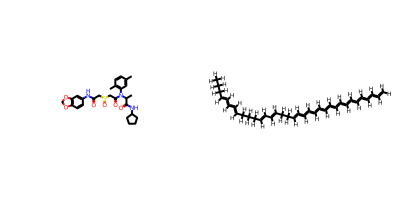

In [27]:
'''
Checking the model's ability to reconstruct a molecule from the training dataset
'''

i=2
adjacency_check, features_check = smiles_to_graph(train_df.loc[i]["SMILES"])
score_check = [train_df.loc[i]["Score"]]
molobj = Chem.MolFromSmiles(train_df.loc[i]["SMILES"])
adj0 = np.expand_dims(adjacency_check,axis=0)
feature0 = np.expand_dims(features_check,axis=0)
score0 = np.expand_dims(score_check,axis=0)
print(adj0.shape)
print(feature0.shape)
print(type(score0))

z_mean, z_log_var = vae.encoder([adj0, feature0 , score0])
z = vae.sampling([z_mean, z_log_var]).numpy()
print(type(z))
adj_reconstruction, feat_reconstruction = vae.decoder([z, score0])
adjacency = tf.argmax(adj_reconstruction, axis=1)
adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)

# Remove potential self-loops from adjacency
adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
# obtain one-hot encoded feature tensor
features = tf.argmax(feat_reconstruction, axis=2)
features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
mole_pred = graph_to_molecule(adjacency.numpy()[0], features.numpy()[0])
Draw.MolsToGridImage([molobj,mole_pred], molsPerRow=2,)


In [28]:
'''
Checking the model's ability to reconstruct a molecule from the training dataset
'''

i=10
adjacency_check, features_check = smiles_to_graph(train_df.loc[i]["SMILES"])
score_check = [train_df.loc[i]["Score"]]
molobj = Chem.MolFromSmiles(train_df.loc[i]["SMILES"])
adj0 = np.expand_dims(adjacency_check,axis=0)
feature0 = np.expand_dims(features_check,axis=0)
score0 = np.expand_dims(score_check,axis=0)
print(adj0.shape)
print(feature0.shape)
print(score0.shape)


(1, 5, 50, 50)
(1, 50, 12)
(1, 1)


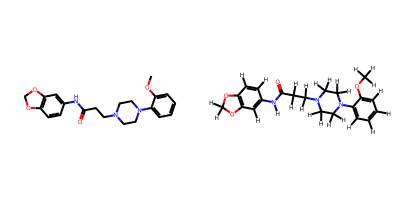

In [29]:
mole_pred = graph_to_molecule(adj0[0], feature0[0])
Draw.MolsToGridImage([molobj,mole_pred], molsPerRow=2,)

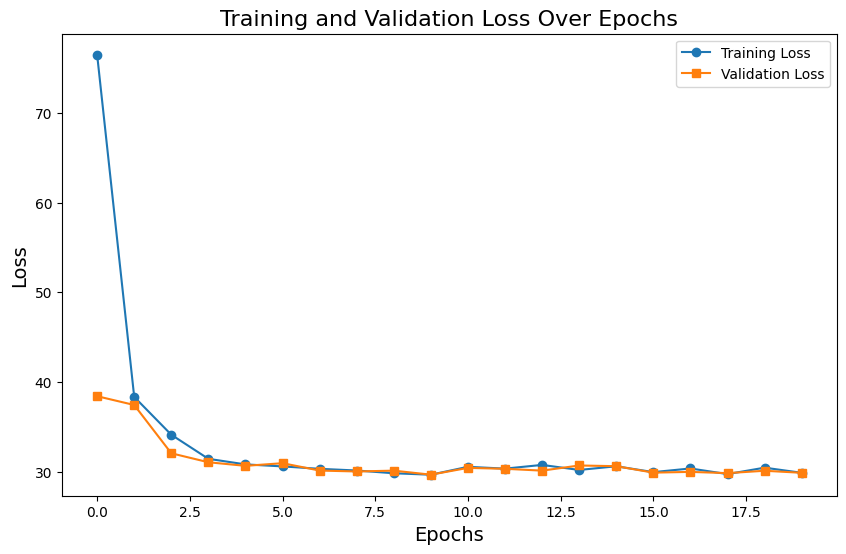

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), train_loss_list, label='Training Loss', marker='o')
plt.plot(range(EPOCHS), val_loss_list, label='Validation Loss', marker='s')

# Add title and labels
plt.title('Training and Validation Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.show()

## Visualize latent space

In [ ]:
# Compare latent space generation from original -- Jinyu Xu, Gloria Wang, Neil Tran

adj_test, fea_test, score_test = [], [], []

for idx in range(len(test)):
    adjacency, features = smiles_to_graph(test.loc[idx]["SMILES"])
    score = test.loc[idx]["Score"]
    adj_test.append(adjacency)
    fea_test.append(features)
    score_test.append(score)


adj_test = np.array(adj_test)
fea_test = np.array(fea_test)
score_test_ = np.array(score_test).reshape(-1,1)

score_test_n = scaler.transform(score_test_)

In [32]:
ls_train = vae.encoder.predict([adj_train, fea_train, score_train_])
ls_test = vae.encoder.predict([adj_test, fea_test, score_test_])

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step


In [33]:
ls_train_ = np.array(ls_train)
ls_test_ = np.array(ls_test)

In [34]:
z_mean, _ = vae.encoder.predict([adj_test, fea_test, score_test_])

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step


In [35]:
latent_noise = np.random.normal(scale=0.1, size=z_mean.shape)  # Adjust scale as needed
adj_pred, feature_pred = vae.decoder.predict([z_mean, score_test_])
print("Shape of adj_pred:", adj_pred.shape)
print("Shape of feature_pred:", feature_pred.shape)

# Reconstruct molecules
gen_molecules = [
    graph_to_molecule(adj_pred[i], feature_pred[i])
    for i in range(adj_pred.shape[0])
]

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Shape of adj_pred: (2510, 5, 50, 50)
Shape of feature_pred: (2510, 50, 12)


In [36]:
from scipy.stats import pearsonr

# Correlate latent dimensions with molecular scores
correlations = [pearsonr(z_mean[:, i], score_test_.flatten())[0] for i in range(z_mean.shape[1])]
print("Correlations between latent dimensions and scores:", correlations)

Correlations between latent dimensions and scores: [-0.005704212737532405, 0.05657733888339497, 0.672312610256419, 0.1368001694991941, -0.9026051712166592, 0.4960607980419289, 0.7616879827302385, 0.9090844298618619, 0.6531743081754462, 0.8744688219369074, -0.8547670472855493, -0.3659247453304275, 0.720219545466485, -0.5137429430613006, 0.25749188064004364, -0.37936926645311797, -0.8372240652056102, -0.2066863991938661, 0.5150654404294894, -0.10627539613095285, -0.5822151514138012, -0.15600963684077734, 0.7387116249494456, -0.4812463085041968, -0.7217089300181155, 0.591457573357538, 0.7535813363535544, 0.7038671961862132, -0.37642420786494496, 0.8608860815559112, 0.5605661819551893, -0.1908798342028874, 0.09473154339256779, -0.8493098731264417, -0.7601220183561707, -0.8837026804238621, -0.779730246432315, -0.8555920225383244, 0.5844143960329795, 0.11227147946932675, 0.7578835082828514, 0.4277340302669531, 0.16850333733809258, -0.8579885099038314, -0.06207670443372568, 0.3013730474748957

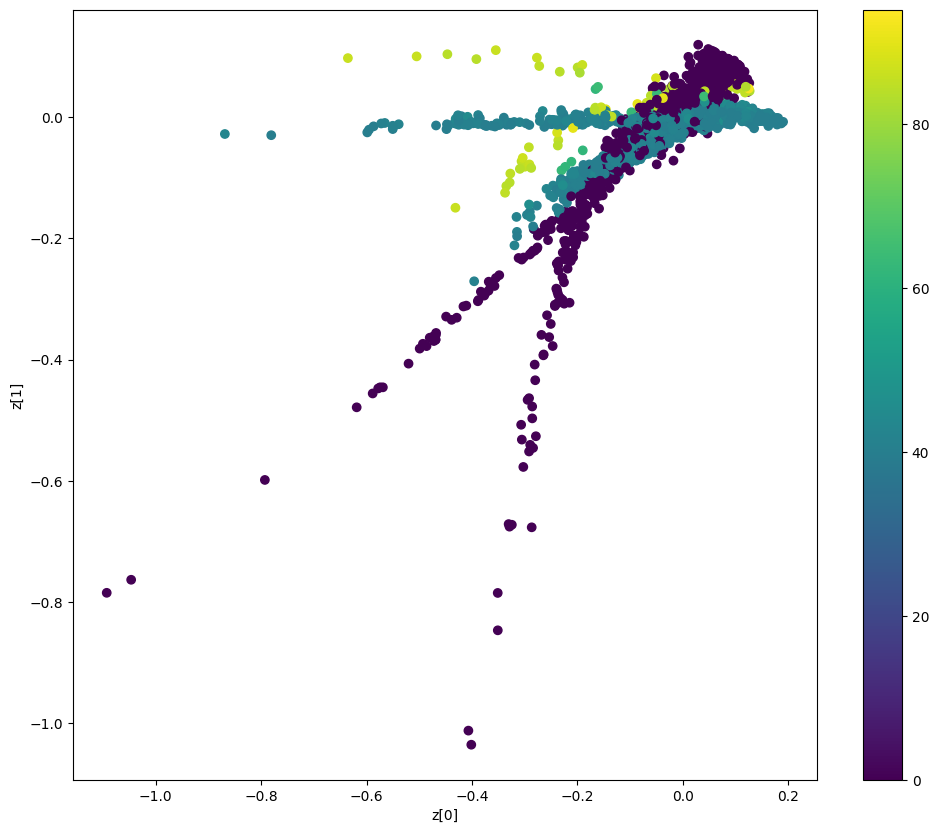

In [37]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=score_test_)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

In [38]:
z_mean2, _2 = vae.encoder.predict([adj_train, fea_train, score_train_])

251/251 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step


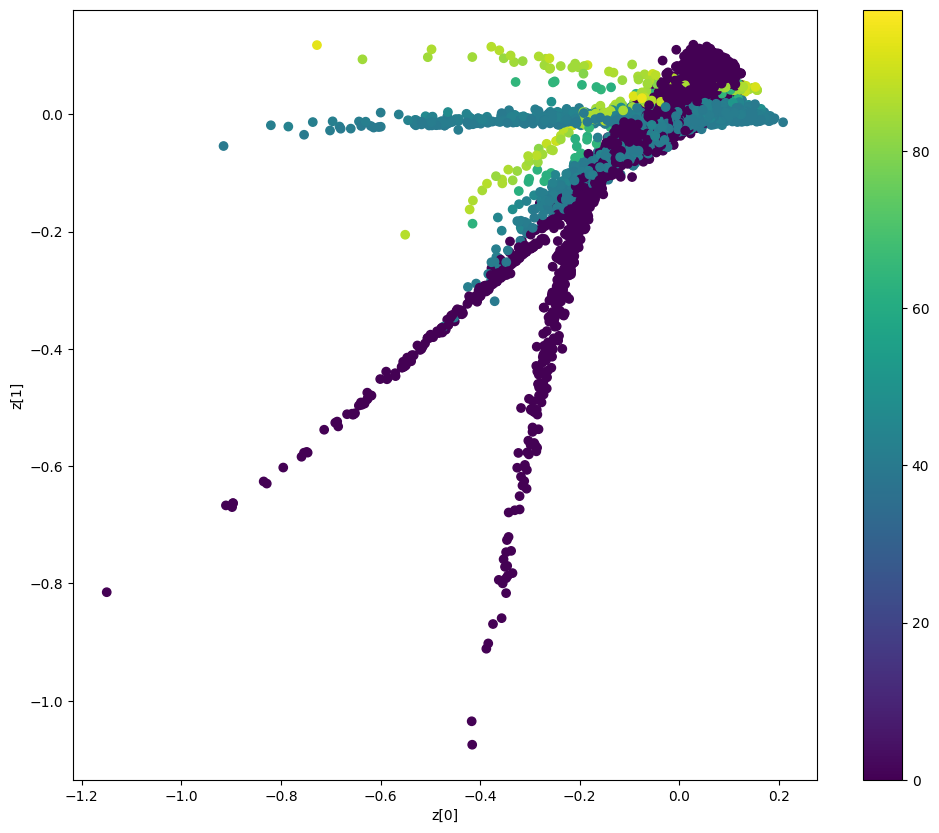

In [39]:
plt.figure(figsize=(12, 10))
plt.scatter(z_mean2[:, 0], z_mean2[:, 1], c=score_train_)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

## Model Inferencing

We would be inferring our model to predict over random latent space and try to generate 100 new valid molecules.

### Generate unique Molecules with the model

In [ ]:
# Modified from https://keras.io/examples/generative/molecule_generation/ -- Jinyu Xu, Neil Tran
def inference(model=vae, batch_size=1000, dim = LATENT_DIM, activity=10):
    z = np.random.normal(size=(batch_size, dim))
    activityarray = (np.zeros(batch_size) + activity).reshape(-1,1)

    reconstruction_adjacency, reconstruction_features = model.decoder.predict([z,activityarray])
    # obtain one-hot encoded adjacency tensor
    adjacency = tf.argmax(reconstruction_adjacency, axis=1)
    adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
    # Remove potential self-loops from adjacency
    adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
    # obtain one-hot encoded feature tensor
    features = tf.argmax(reconstruction_features, axis=2)
    features = tf.one_hot(features, depth=ATOM_DIM, axis=2)

    return [
        graph_to_molecule(adjacency[i].numpy(), features[i].numpy())
        for i in range(batch_size)
    ]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sanitization failed: Explicit valence for atom # 0 B, 47, is greater than permitted
Sanitization failed: Explicit valence for atom # 0 F, 100, is greater than permitted
Sanitization failed: Explicit valence for atom # 0 S, 99, is greater than permitted
Sanitization failed: Explicit valence for atom # 0 Br, 99, is greater than permitted
Sanitization failed: Explicit valence for atom # 3 Cl, 3, is greater than permitted
Sanitization failed: Explicit valence for atom # 0 C, 9, is greater than permitted
Sanitization failed: Explicit valence for atom # 0 C, 18, is greater than permitted
Sanitization failed: Explicit valence for atom # 0 S, 96, is greater than permitted
Sanitization failed: Explicit valence for atom # 19 C, 8, is greater than permitted
Sanitization failed: Explicit valence for atom # 0 S, 102, is greater than permitted
Sanitization failed: Explicit valence for atom # 0 S, 103, is greater than permitted
Sanitization failed: Explicit vale

/Users/thinh/Library/Python/3.12/lib/python/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


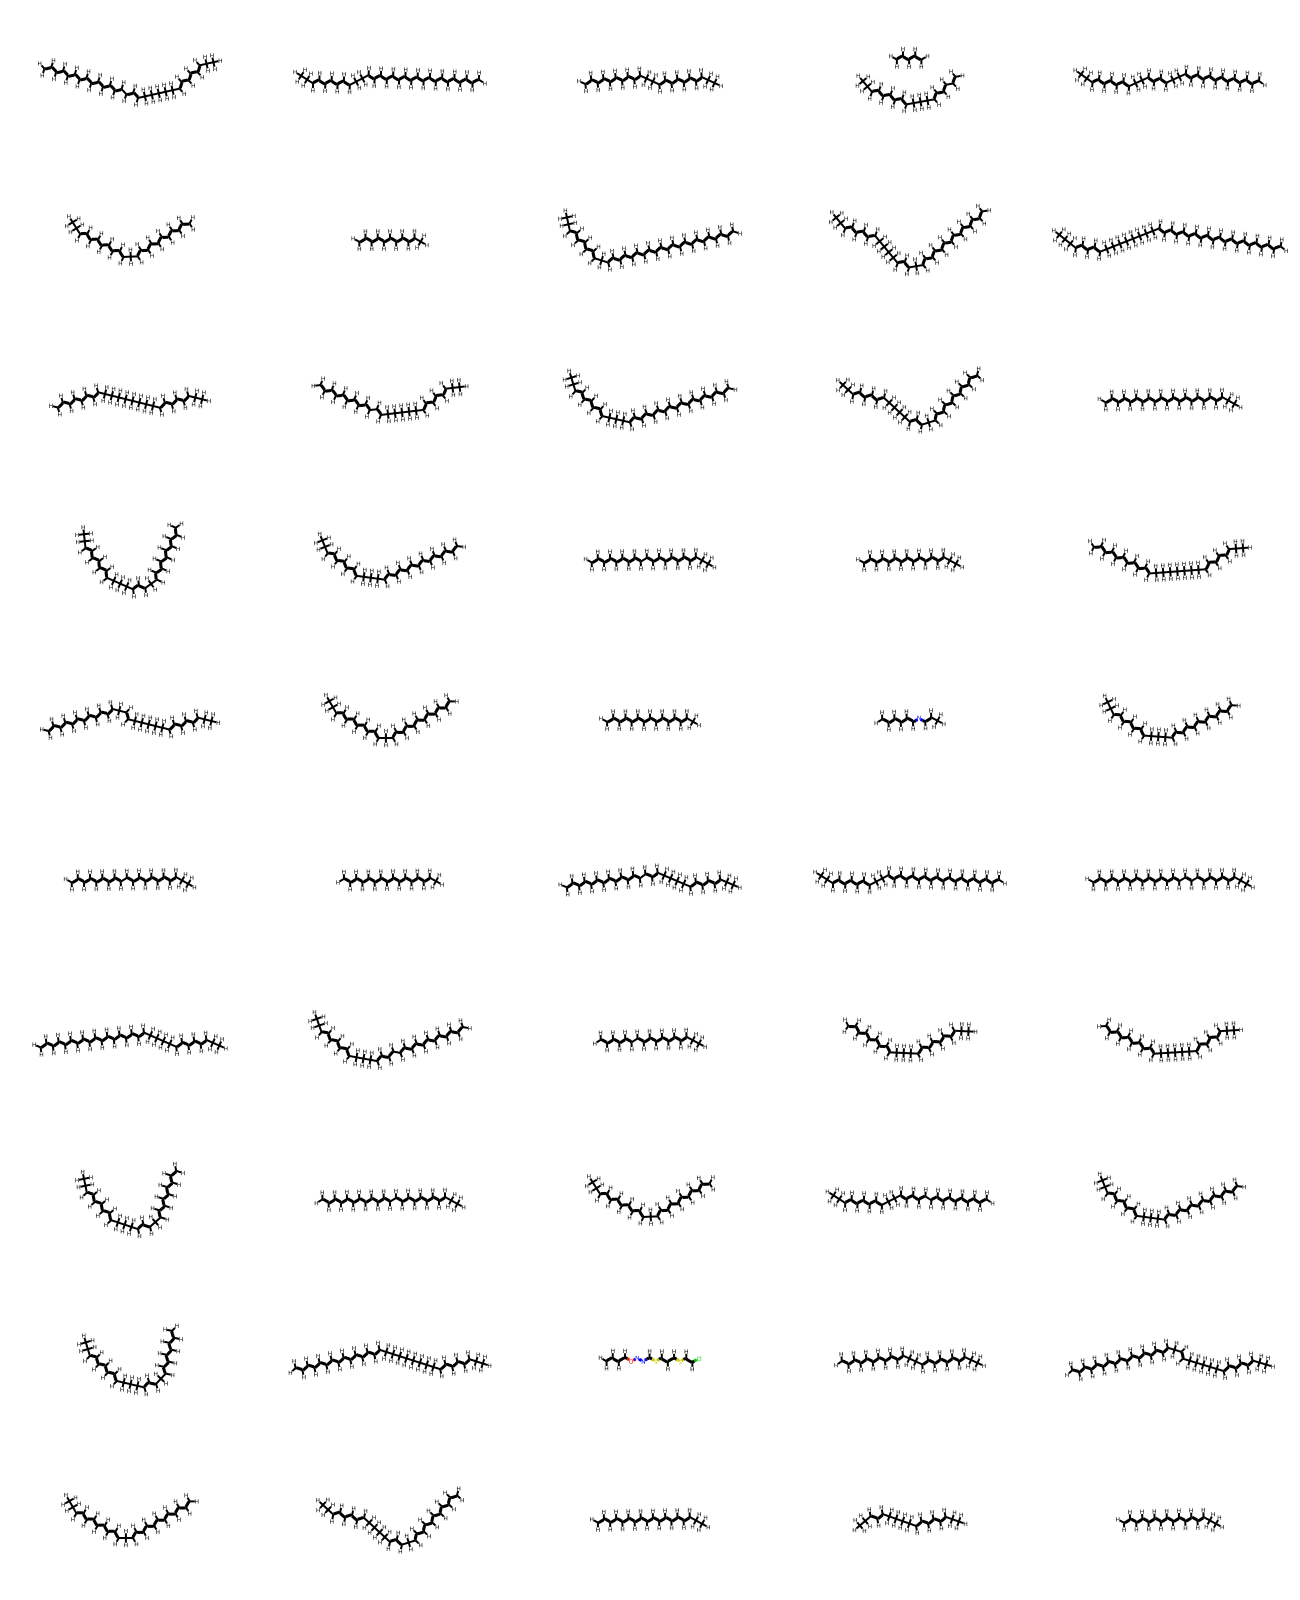

In [41]:
gen_mols = inference(batch_size=1000,activity=0.5)
MolsToGridImage([m for m in gen_mols if m is not None][:1000], molsPerRow=5, subImgSize=(260, 160))